In [4]:
import torch
import torchvision.models as models
from torchvision import models,datasets,transforms
import os
import shutil
import pandas as pd
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

In [5]:
def copy_all_to_dataset_analysis(data_dir, output_dir):
    # Define class mapping for unifying class names
    class_mapping = {
        "cardboard": "cardboard",  
        "Cardboard": "cardboard",  
        "Glass": "glass",
        "glass": "glass",
        "Metal": "metal",
        "metal": "metal",
        "paper": "paper",
        "Paper": "paper",
        "plastic": "plastic",
        "Plastic": "plastic",
        "trash": "trash",
        "Food Organics": "trash",
        "Miscellaneous Trash": "trash",
    }
 
    # Folders to ignore
    ignored_folders = {"Textile Trash", "Vegetation"}
 
    # Define dataset_analysis directory
    dataset_analysis_dir = os.path.join(output_dir, 'dataset_analysis')
    os.makedirs(dataset_analysis_dir, exist_ok=True)
 
    # Data storage for CSV logging
    records = []
 
    # Process each class directory
    for class_name in os.listdir(data_dir):
        if class_name in ignored_folders:
            print(f"Skipping {class_name} (ignored)")
            continue  # Skip ignored folders
 
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
 
        # Map class name (default to original if no mapping exists)
        mapped_class = class_mapping.get(class_name, class_name)
 
        # Create mapped class directory in dataset_analysis set
        class_dataset_analysis_dir = os.path.join(dataset_analysis_dir, mapped_class)
        os.makedirs(class_dataset_analysis_dir, exist_ok=True)
 
        # Get all images
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
 
        print(f"Copying {len(images)} images from {class_name} to {mapped_class} in dataset_analysis set...")
 
        # Copy all images to dataset_analysis set
        for image in images:
            dest = os.path.join(class_dataset_analysis_dir, os.path.basename(image))
            shutil.copy(image, dest)
            records.append((os.path.basename(image), class_name, mapped_class, "dataset_analysis"))  # Save mapping data
 
    # Save mapping information to CSV
    df = pd.DataFrame(records, columns=['filename', 'original_class', 'mapped_class', 'split_type'])
    df.to_csv(os.path.join(output_dir, 'class_mapping.csv'), index=False)
 
    print("All images successfully copied to the dataset_analysis set!")
 
# Set the paths
original_data_dir = '../data/realwaste-main/RealWaste'
output_data_dir = '../data/realwaste-main'
 
# Copy all images to dataset_analysis set
copy_all_to_dataset_analysis(original_data_dir, output_data_dir)

Copying 500 images from Paper to paper in dataset_analysis set...
Copying 790 images from Metal to metal in dataset_analysis set...
Copying 461 images from Cardboard to cardboard in dataset_analysis set...
Copying 411 images from Food Organics to trash in dataset_analysis set...
Copying 420 images from Glass to glass in dataset_analysis set...
Skipping Vegetation (ignored)
Skipping Textile Trash (ignored)
Copying 495 images from Miscellaneous Trash to trash in dataset_analysis set...
Copying 921 images from Plastic to plastic in dataset_analysis set...
All images successfully copied to the dataset_analysis set!


In [6]:
dir_trashnet = '../data/dataset_split'
dir_realwaste = '../data/realwaste-main'

params = { 'batch_size':16,
           'shuffle':True,
           'num_workers':4 }

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
trashnet_dataset = datasets.ImageFolder(os.path.join(dir_trashnet, 'test'),transform = transform)
realwaste_dataset = datasets.ImageFolder(os.path.join(dir_realwaste, 'dataset_analysis'),transform = transform)

trashnet_dataloader = torch.utils.data.DataLoader(trashnet_dataset, **params)
realwaste_dataloader = torch.utils.data.DataLoader(realwaste_dataset, **params)

class_names = trashnet_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

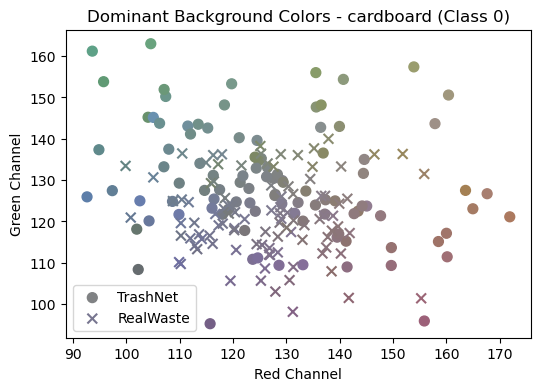

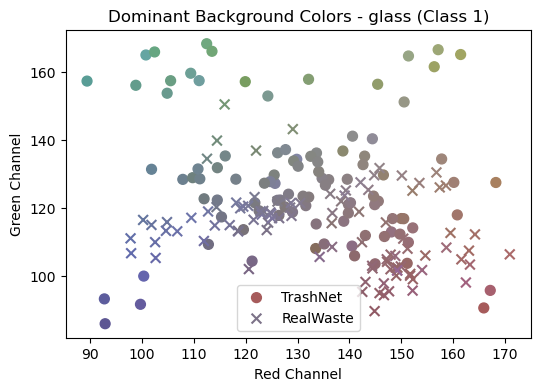

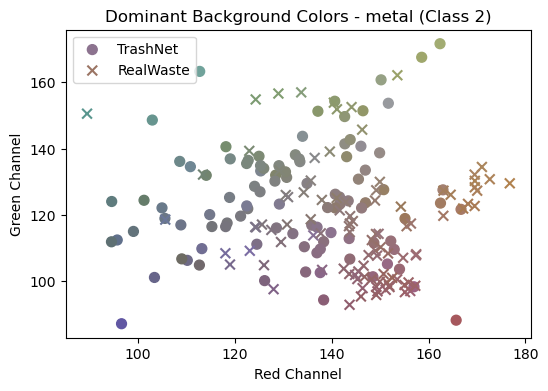

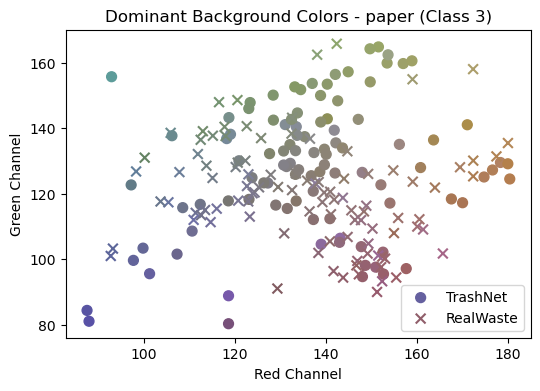

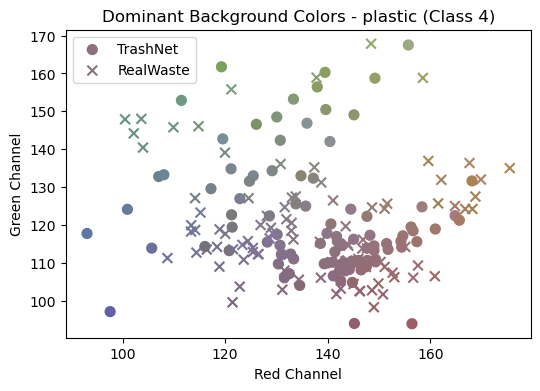

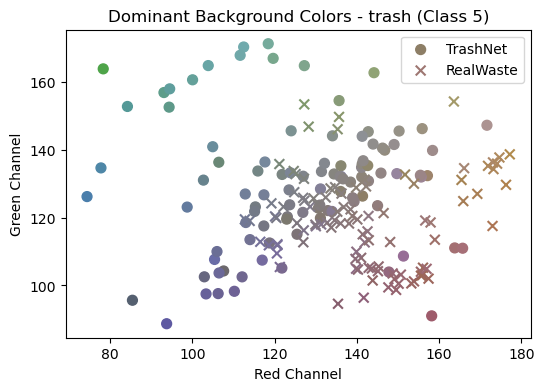

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from collections import defaultdict


def get_dominant_color(image, k=3):
    """Extract dominant colors from an image using K-means clustering."""
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    image = image.reshape(-1, 3)  # Flatten
    kmeans = KMeans(n_clusters=k, random_state=42).fit(image)
    return kmeans.cluster_centers_

def analyze_backgrounds(dataloader, dataset_name, num_samples_per_class=100):
    """Extract dominant background colors per class."""
    class_colors = defaultdict(list)

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            class_id = label.item()
            if len(class_colors[class_id]) >= num_samples_per_class:
                continue  # Skip if enough samples for the class
            
            dom_color = get_dominant_color(img)
            class_colors[class_id].append(dom_color.mean(axis=0))

    return class_colors  # Return extracted colors for comparison

# Extract colors from both datasets
trashnet_colors = analyze_backgrounds(trashnet_dataloader, "TrashNet")
realwaste_colors = analyze_backgrounds(realwaste_dataloader, "RealWaste")

# Plot per class
for class_id in set(trashnet_colors.keys()).union(realwaste_colors.keys()):
    plt.figure(figsize=(6, 4))
    
    if class_id in trashnet_colors:
        trashnet_data = np.array(trashnet_colors[class_id])
        plt.scatter(trashnet_data[:, 0], trashnet_data[:, 1], c=trashnet_data / 255.0, s=50, label="TrashNet")

    if class_id in realwaste_colors:
        realwaste_data = np.array(realwaste_colors[class_id])
        plt.scatter(realwaste_data[:, 0], realwaste_data[:, 1], c=realwaste_data / 255.0, s=50, marker="x", label="RealWaste")

    plt.xlabel("Red Channel")
    plt.ylabel("Green Channel")
    plt.title(f"Dominant Background Colors - {class_names[class_id]}")
    plt.legend()
    plt.show()


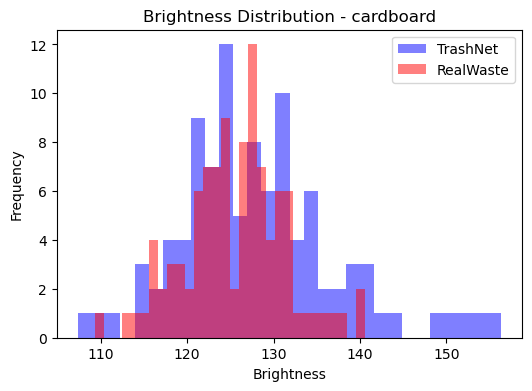

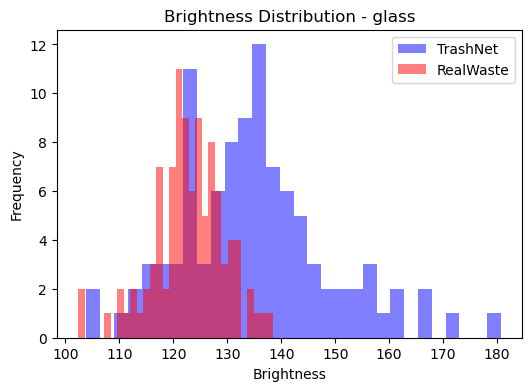

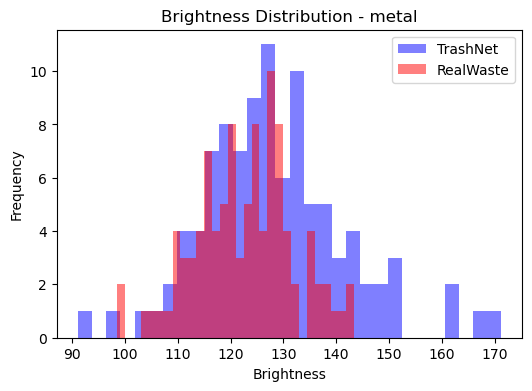

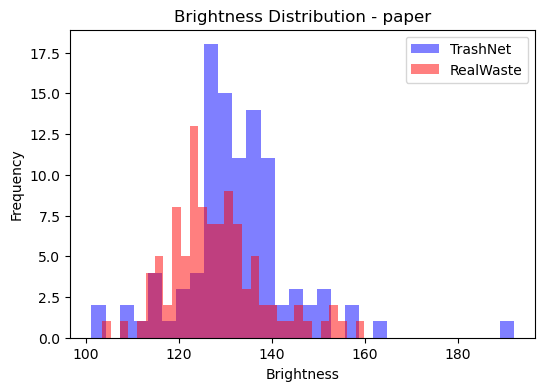

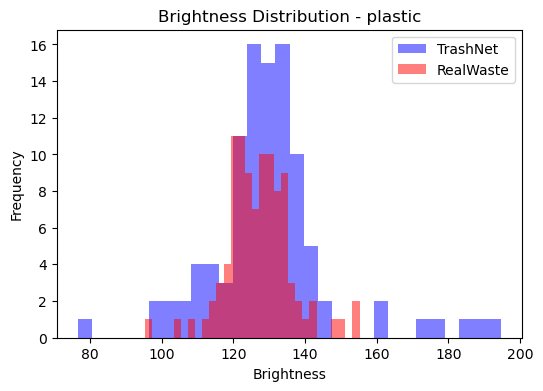

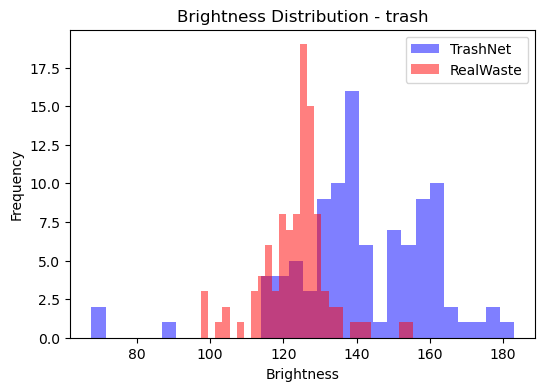

In [9]:
def calculate_brightness(image):
    """Compute the brightness of an image (grayscale intensity)."""
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    gray = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
    return np.mean(gray)  # Return mean brightness

def analyze_brightness(dataloader, dataset_name, num_samples_per_class=100):
    """Extract brightness per class."""
    class_brightness = defaultdict(list)

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            class_id = label.item()
            if len(class_brightness[class_id]) >= num_samples_per_class:
                continue  # Skip if enough samples for the class
            
            brightness = calculate_brightness(img)
            class_brightness[class_id].append(brightness)

    return class_brightness  # Return extracted brightness values for comparison

# Extract brightness data from both datasets
trashnet_brightness = analyze_brightness(trashnet_dataloader, "TrashNet")
realwaste_brightness = analyze_brightness(realwaste_dataloader, "RealWaste")

# Plot per class
for class_id in set(trashnet_brightness.keys()).union(realwaste_brightness.keys()):
    plt.figure(figsize=(6, 4))
    
    if class_id in trashnet_brightness:
        plt.hist(trashnet_brightness[class_id], bins=30, alpha=0.5, color="blue", label="TrashNet")

    if class_id in realwaste_brightness:
        plt.hist(realwaste_brightness[class_id], bins=30, alpha=0.5, color="red", label="RealWaste")

    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.title(f"Brightness Distribution - {class_names[class_id]}")
    plt.legend()
    plt.show()
